In [1]:
# import libraries
# Always run this cell first!
import numpy as np
import pandas as pd
import math

import scipy
import statsmodels.api # appear to need to import the api as well as the library itself for the interpreter to find the modules
import statsmodels as sm

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode(connected=True) # make plotly work with Jupyter Notebook using CDN

# Foundations of Statistical Inference

This chapter is all about how to use statistics to make decision from data, a process known as statistical inference. Because data is usually incomplete and has a lot of variability, this decision making process inherently contains a lot of uncertainty. But the difficulty shouldn't deter us! The statistical decision-making process is based on a robust theory of probability, and one of the easiest ways to illustrate this theory is using computation. 

In this section we take a look at one of the main probability results that allows us to do statistical inference: the Central Limit Theorem. We'll then show how the Central Limit Theorem leads us to the first tool of statistical inference, the confidence interval.

## Sampling and the Central Limit Theorem

To get us thinking about statistical decision-making, let's imagine a hypothetical scenario where we are an agent for a football player (that's *soccer* to Americans). As an agent, we want to negotiate a good deal for our client, who plays in the English Premier League. To do this we might need to first try to estimate the average salary for all players in the league.

Unlike a real-world statistical estimate, in this scenario we have access to the entire *population* of player salaries for the 2022-23 Premier League season. This data comes from [FBref](https://fbref.com/en/comps/9/wages/Premier-League-Wages) and is in units of pounds (£, GBP) per week.

Here we will read in the data, which is in the file `EPL_wages_22_23.csv`, and display the first 10 rows. These correspond to the 10 highest paid players---you may recognize some of the names!

In [2]:
salaries = pd.read_csv("EPL_wages_22_23.csv").drop(columns=["Rk","Notes", "Player-additional","Annual Wages"])
salaries["Weekly Wages (GBP)"] = salaries["Weekly Wages"].str.extract('(\d+)').astype(int)
salaries.head(n=10)

Player   Nation   Pos            Squad  Age  \
0  Cristiano Ronaldo   pt POR    FW   Manchester Utd   37   
1    Kevin De Bruyne   be BEL    MF  Manchester City   31   
2       David de Gea   es ESP    GK   Manchester Utd   31   
3     Erling Haaland   no NOR    FW  Manchester City   22   
4       Jadon Sancho  eng ENG  FWMF   Manchester Utd   22   
5      Mohamed Salah   eg EGY    FW        Liverpool   30   
6     Raphaël Varane   fr FRA    DF   Manchester Utd   29   
7    Raheem Sterling  eng ENG  FWMF          Chelsea   27   
8           Casemiro   br BRA    MF   Manchester Utd   30   
9      Jack Grealish  eng ENG    FW  Manchester City   26   

                  Weekly Wages  Weekly Wages (GBP)  
0  £ 515000 (€ 583130 $619550)              515000  
1  £ 400000 (€ 452916 $481204)              400000  
2  £ 375000 (€ 424609 $451129)              375000  
3  £ 375000 (€ 424609 $451129)              375000  
4  £ 350000 (€ 396302 $421053)              350000  
5  £ 350000 (€ 396302 $421053)              350000  
6  £ 340000 (€ 384979 $409023)              340000  
7  £ 325000 (€ 367994 $390978)              325000  
8  £ 300000 (€ 339687 $360903)              300000  
9  £ 300000 (€ 339687 $360903)              300000

One of the key ideas in statistics is that even if the distribution of the population (in this case, footballers' weekly salaries) is not normal, the distribution of the average salary of a large number of *randomly selected* footballers *does* have an (approximately) normal distribution. Hence, even though any estimation we make from a sample contains some uncertainty, we can quantify that uncertainty and make the best decision possible.

*Note:* Of course, there are probably a lot more helpful things to calculate than simply the average player salary. For instance, we could look at salaries of players with similar statistics. Take a look at the section on linear algebra and clustering. **(add link here later)**

We begin by taking a look at the population of all player salaries. Note that this distribution is highly skewed, and far from being normal. In fact, the distribution of player salaries is modeled fairly well with an exponential distribution! Below, we calculate the mean and standard deviation of the weekly wages from this dataset, and compare the histogram of weekly wages to the normal distribution with the same mean and standard deviation as well as the exponential distribution with the same mean.

In [3]:
pop_mean = salaries["Weekly Wages (GBP)"].mean()
pop_sd = salaries["Weekly Wages (GBP)"].std()
print(f"Population mean is {pop_mean:.3f}, standard deviation is {pop_sd:.3f}.")

Population mean is 69108.187, standard deviation is 66860.742.


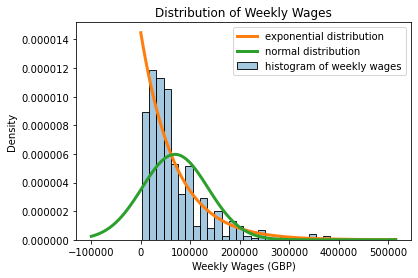

In [4]:
weekly_wages = salaries['Weekly Wages (GBP)']

# use default seaborn palette
palette = iter(sns.color_palette())

# plot histogram
axis = sns.histplot(
    data = weekly_wages,
    stat = 'density',
    color = next(palette), # use next color in palette
    alpha = 0.4,
    label = 'histogram of weekly wages'
)

# plot exponential distribution
x = np.linspace(0, max(weekly_wages), 100)
axis.plot(
    x,
    scipy.stats.expon.pdf(x, scale=np.mean(weekly_wages)),
    color = next(palette), # use next color in palette
    linewidth = 3,
    label = 'exponential distribution'
)

# plot normal distribution
x = np.linspace(-100000, max(weekly_wages), 100)
axis.plot(
    x,
    scipy.stats.norm.pdf(x, loc=np.mean(weekly_wages), scale=np.std(weekly_wages)),
    color = next(palette), # use next color in palette
    linewidth = 3,
    label = 'normal distribution'
)

axis.ticklabel_format(style='plain', axis='y')

axis.set_title("Distribution of Weekly Wages")
axis.legend();

In our hypothetical scenario, let's imagine that we didn't have access to *all* of the data, but only knew the salaries for 35 random players. We could take the average salary of those 35 players, but would it be close to the real average salary of *all* the players? 

The following code will take a random sample of 35 players, and compute the (sample) average of the salaries of those players. Is it close to the actual salary? 

In [5]:
my_sample = salaries.sample(n=35)

sample_mean = my_sample["Weekly Wages (GBP)"].mean()
sample_sd = my_sample["Weekly Wages (GBP)"].std()

print(f"Sample mean is {sample_mean:.3f}.")

Sample mean is 69442.857.


It's important to note that this sample mean is just one possible value. If we had taken a different random sample of 35 players, we would get a different sample average. You can see this for yourself if you run the code several times. We thus understand the sample mean as a random variable.

As an example, if we randomly selected highly-paid players such as Cristiano Ronaldo, we would expect our sample average to be higher than the population average. If we randomly selected a lot of young players or reserves, we would expect our sample average to be lower. But how much lower or higher is possible? How much lower or higher should we expect? We can answer this question by understanding sampling distributions. In other words, if the sample mean is a random variable, what is its distribution?

Because we have access to the entire population of data, we can explore this idea through simulation. Instead of taking just one sample mean from a sample of size 35, we can take many of them and look at the possible values.

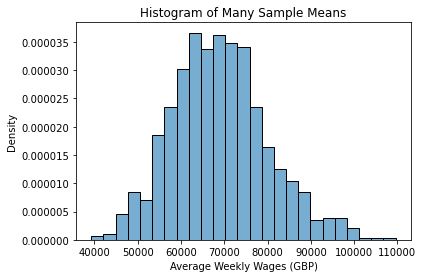

In [6]:
# calculate the means of 1000 random samples of size 35
many_sample_means = [salaries.sample(n=35)["Weekly Wages (GBP)"].mean() for i in range(1000)]

# plot histogram of many_sample_means
axis = sns.histplot(
    data = many_sample_means,
    stat = 'density',
    alpha = 0.6,
)
axis.ticklabel_format(style='plain', axis='y')
axis.set_xlabel("Average Weekly Wages (GBP)")
axis.set_title("Histogram of Many Sample Means");

Now let's compare this to the theory. What does the Central Limit Theorem tell us? 

If the sample size is "large enough", then the sample mean, considered as a random variable, is approximately normally distributed with the same mean as the population and with standard deviation equal to the population standard deviation divided by the sample size. In mathematical language,

\begin{equation}
    \displaystyle \overline{X} \sim N\left(\mu, \frac{\sigma}{\sqrt{n}}\right),
\end{equation}

where $\overline{X}$ is the sample mean, $\mu$ is the population mean, $\sigma$ is the population standard deviation, and $n$ is the sample size.

In our case, $n = 35$, and the population mean and standard deviation were calculated above. Let's replot our histogram of `many_sample_means`, along with the normal distribution with the same mean and standard deviation, and see how it matches up with the theory.

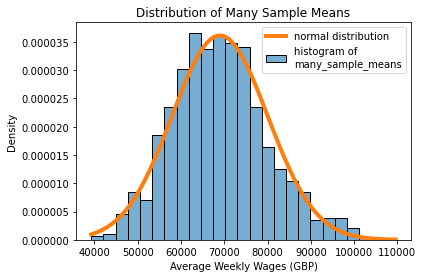

In [7]:
# Same histogram as above, with normal distribution overlay

# use default seaborn palette
palette = iter(sns.color_palette())

# plot histogram
histcolor = next(palette) # use next color in palette
axis = sns.histplot(
    data = many_sample_means,
    stat = 'density',
    color = histcolor,
    alpha = 0.6,
    label = 'histogram of\nmany_sample_means'
)

# plot normal distribution
x = np.linspace(min(many_sample_means), max(many_sample_means), 100)
axis.plot(
    x,
    scipy.stats.norm.pdf(x, loc=np.mean(many_sample_means), scale=np.std(many_sample_means)),
    color = next(palette), # use next color in palette
    linewidth = 4,
    label = 'normal distribution'
)

axis.ticklabel_format(style='plain', axis='y')
axis.set_xlabel("Average Weekly Wages (GBP)")
axis.set_title("Distribution of Many Sample Means")
axis.legend();

We now see that even though the average weekly salary of 35 players is variable, and changes based on which 35 players we get, overall we have a good idea of which values we're likely to get!

All of this depends on the sample size being "large enough", which leaves us with a big question: how large is large enough?

You can play around with the interactive widget below to try different sample sizes and see how well the theoretical normal distribution matches up with the sampling distribution. Given a sample size, the widget plots the average of 10000 random samples of that size from the salary data, overlaid with the normal distribution with the same mean and standard deviation.

Drag the slider to select different sample sizes, and click the labels in the legend to hide or show different parts of the graph. Notice how the histogram of the averages fits the normal distribution more closely as the sample size increases.

In [8]:
# Get the average of reps samples from data with the given sample size and replacement policy
def get_sample_avg(data, size, reps, replace=False):
    return [np.mean(data.sample(size, replace=replace).to_numpy()) for i in range(reps)]

# Define sample sizes and number of repetitions for sampling
sample_sizes = np.arange(5, 45, 5)
n = len(sample_sizes)
reps = 10000

# Use default seaborn palette (reference: https://josephlemaitre.com/2022/06/use-a-seaborn-color-palette-for-plotly-figures/)
plotly_palette = iter([f"rgb({c[0]*256}, {c[1]*256}, {c[2]*256})" for c in sns.color_palette()])
histcolor = next(plotly_palette)
normcolor = next(plotly_palette)

# Create figure
fig = go.Figure()

# Set consistent limits for axes in all traces
xlim = (12000, 200000)
ylim = (0, 4.5e-05)

# Define which sample size will be initially visible
# (note that this is the index of the sample size)
initial_sample_size_index = 0

# Get averages for all possible sample sizes
# averages[i] is the average of reps samples of size sample_sizes[i] (with replacement)
averages = [get_sample_avg(salaries["Weekly Wages (GBP)"], size, reps, replace=True) for size in sample_sizes]

# Add histogram traces
# (the histogram for averages[i] is plotted as the ith trace, fig.data[i])
for i, avg in enumerate(averages):
    fig.add_trace(
        go.Histogram(
            # initially, only the histogram for initial_sample_size should be visible
            visible = True if i == initial_sample_size_index else False,
            name = "histogram<br>of averages", # label for legend
            x = avg,
            marker = { "color": histcolor },
            hoverinfo = "x+y",
            histnorm = "probability density",
        )
    )

# Add normal pdf traces
# (the normal pdf for averages[i] is plotted as the (i+n)th trace, fig.data[i+n])
x = np.linspace(*xlim, 100)
for i, avg in enumerate(averages):
    # determine x-axis limits
    fig.add_trace(
        go.Scatter(
            # initially, only the normal pdf for initial_sample_size should be visible
            visible = True if i == initial_sample_size_index else False,
            line = { "width": 4 },
            marker = { "color": normcolor },
            name = "normal<br>distribution", # label for legend
            hoverinfo = "x+y",
            x = x,
            y = scipy.stats.norm.pdf(x, np.mean(avg), np.std(avg))
        )
    )
    
get_title = lambda i: f"Averages of {reps} Random Samples of Size {sample_sizes[i]}"

# Create steps for the slider to select sample size
steps = []
for i in range(n):
    steps.append({
        "method": "update",
        "args": [ # arguments to pass to the update method
            # update visibility so only the histogram and normal pdf for this sample size are visible
            { "visible": [True if (j == i or j-n == i) else False for j in range(len(fig.data))] },
            # update the title to reflect the change to the sample size
            { "title": get_title(i) }
        ],
        "label": str(sample_sizes[i]),
    })

# Create a slider using these steps and add it to fig
fig.layout.sliders = [{
    "active": initial_sample_size_index,
    "currentvalue": { "prefix": "Sample Size: " },
    "pad": {"t": 50},
    "steps": steps,
}]

# Set layout settings
fig.update_layout(
    title = {
        "x": 0.5,
        "text": get_title(initial_sample_size_index)
    },
    xaxis = {
        "title": "Average Weekly Wages (GBP)",
        "range": xlim,
        "constrain": "domain",
    },
    yaxis = {
        "title": "Probability Density",
        "tickformat": ".2",
        "range": ylim,
        "constrain": "domain",
    },
    paper_bgcolor = "LightSteelBlue"
)

# Display figure
fig.show()

Statisticians will usually say that a sample size of 30 is large enough. Based on the widget above, would you agree with that? Do the distributions look approximately normal at that sample size?

## Confidence Intervals

In real life, the situation is much different. We will typically only have one sample, and hence one sample mean. We now know that if our sample size $n$ is large enough, we are likely to be close to the true population mean. But how close are we? And can we quantify what "likely" means in this case?

The Central Limit Theorem (CLT) tells us where $\overline X$ is likely to be in relation to $\mu$. Since $\displaystyle \overline{X} \sim N(\mu, \frac{\sigma}{\sqrt{n}})$, we know that 95% of the time, $\overline X$ will fall within a distance of about 2 standard deviations from $\mu$ (technically, the distance is more like 1.96). In other words, 95% of the area under the density function is between $\displaystyle \mu-1.96 \frac{\sigma}{\sqrt{n}}$ and $\displaystyle \mu + 1.96  \frac{\sigma}{\sqrt{n}}$.

The plot below illustrates what 95% of the area under the standard normal density function looks like.

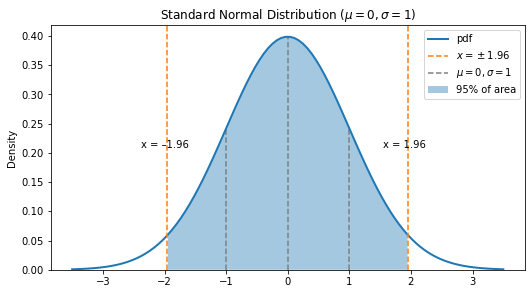

In [9]:
# create plot
fig, ax = plt.subplots(figsize=(8.5,4.5))

# use default seaborn palette
palette = iter(sns.color_palette())

# plot standard normal pdf
x = np.linspace(-3.5, 3.5, 100)
y = scipy.stats.norm.pdf(x, 0, 1)
ax.plot(x, y, color=next(palette), linewidth=2, label='pdf')

# set lower y-axis limit to 0
ax.set_ylim(0, ax.get_ylim()[1])

# plot mean and standard deviation
ax.vlines(x=0, ymin=0, ymax=scipy.stats.norm.pdf(0), linestyle='dashed', color='grey', label='$\mu=0, \sigma=1$')
ax.vlines(x=-1, ymin=0, ymax=scipy.stats.norm.pdf(-1), linestyle='dashed', color='grey')
ax.vlines(x=1, ymin=0, ymax=scipy.stats.norm.pdf(1), linestyle='dashed', color='grey')

# plot and annotate x = ±1.96
linecolor = next(palette)
ax.axvline(-1.96, linestyle='dashed', color=linecolor, label='$x = \pm1.96$')
ax.axvline(1.96, linestyle='dashed', color=linecolor)
half_ylim = sum(ax.get_ylim())/2 # coordinate at middle of y-axis
ax.annotate(
    'x = –1.96',
    xy = (-1.96, half_ylim),
    xytext = (-25.5, 0),
    textcoords = 'offset pixels',
    fontsize = 'medium'
)
ax.annotate(
    'x = 1.96',
    xy = (1.96, half_ylim),
    xytext = (-25.5, 0),
    textcoords = 'offset pixels',
    fontsize = 'medium'
)

# fill between x = ±1.96
ax.fill_between(x, y, where = (x > -1.96) & (x < 1.96), alpha=0.4, label='95% of area')

# set up legend, y-axis label, and title
ax.legend()
ax.set_ylabel('Density')
ax.set_title('Standard Normal Distribution ($\mu=0, \sigma=1$)');

Now we know where $\overline X$ is likely to fall in relation to $\mu$. We can express what we see in the graph as a probability:
\begin{equation}
    P\left(\mu-1.96 \frac{\sigma}{\sqrt{n}} \le \overline X \le \mu + 1.96  \frac{\sigma}{\sqrt{n}}\right) = .95.
\end{equation}
With a little bit of algebraic manipulation, we can write this as an interval for $\mu$:
\begin{equation}
    P\left(\overline{X}-1.96 \frac{\sigma}{\sqrt{n}} \le \mu \le \overline{X} + 1.96  \frac{\sigma}{\sqrt{n}}\right) = .95.
\end{equation}
In the real world, we'll have a value of $\overline{X}$, and we want to know where $\mu$ is. This second interval gives us exactly this! Look at what's on the upper and lower side of the interval: (almost) all things we can calculate from the data, like $\overline X$ and $n$ (we'll discuss how to handle the $\sigma$ in a moment). This gives an interval for $\mu$, the population mean that we can't calculate but want to know.

Let's return to our hypothetical case. We have one sample of $n=35$ players, and one observed sample mean. Since, hypothetically, we don't know the population mean, can we give an interval where we think it is?

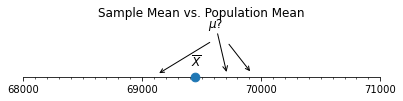

In [10]:
# reference: https://matplotlib.org/stable/gallery/ticks/tick-formatters.html
fig, ax = plt.subplots(figsize=(6.4, 0.4))

# create number line by hiding unneeded elements of plot
ax.yaxis.set_major_locator(ticker.NullLocator())
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

# set up number line limits
ax.set_xlim(1000*((sample_mean-999)//1000), 1000*((sample_mean+1999)//1000))
ax.set_ylim(0, 1)

# set up number line tick marks
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.xaxis.set_ticks_position('bottom')

# plot sample mean
ax.scatter(sample_mean, 0, s = 75, clip_on=False, zorder=10)
ax.annotate(
    '$\overline{X}$',
    xy = (sample_mean, 0),
    xytext = (-4, 10),
    textcoords = 'offset pixels',
    fontsize = 'large',
)

# plot possible locations for population mean
ax.annotate(
    '$\mu$?',
    xy = (sample_mean+275, 0),
    xytext = (-20, 50),
    textcoords = 'offset pixels',
    arrowprops = { 'arrowstyle': '->', 'shrinkA': 0, 'shrinkB': 5 },
    fontsize = 'large',
)
ax.annotate(
    '',
    xy = (sample_mean-350, 0),
    xytext = (sample_mean+175, 1.75),
    arrowprops = { 'arrowstyle': '->', 'shrinkA': 7, 'shrinkB': 7 },
)
ax.annotate(
    '',
    xy = (sample_mean+500, 0),
    xytext = (sample_mean+250, 1.75),
    arrowprops = { 'arrowstyle': '->', 'shrinkA': 7, 'shrinkB': 7 },
)
ax.set_title('Sample Mean vs. Population Mean', y = 2.5);

We know from above that there is a 95% probability that the interval $\left(\overline{X}-1.96 \frac{\sigma}{\sqrt{n}}, \overline{X} + 1.96  \frac{\sigma}{\sqrt{n}}\right)$ contains $\mu$. Let's compute it!

We have access to the sample mean $\overline X$:

In [11]:
print(f"Sample mean is {sample_mean:.3f}.")

Sample mean is 69442.857.


We don't know the population standard deviation $\sigma$, but we might expect that the sample standard deviation $S$ is sufficiently close. If you don't believe that, we could also use a T-distribution, introduced in the next section. But in this case, our sample size is $n=35$, which is large enough to use $S$ in place of $\sigma$.

In [12]:
print(f"Sample standard deviation is {sample_sd:.3f}.")

Sample standard deviation is 83059.048.


Let's put it all together based on our formula above:

In [13]:
lower_ci = sample_mean - 1.96 * sample_sd / np.sqrt(35)
upper_ci = sample_mean + 1.96 * sample_sd / np.sqrt(35)

print(f"95% confidence interval is ({lower_ci:.3f}, {upper_ci:.3f}).")

95% confidence interval is (41925.356, 96960.359).


We are 95% confident that the average weekly salary for premier league players falls in the interval we calculated. 

In our case, we actually have access to the real population parameter. Does our calculated interval actually contain the true population mean $\mu$? Let's visualize it:

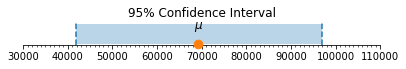

In [14]:
# create plot
fig, ax = plt.subplots(figsize=(6.4, 0.4))
ax.set_title("95% Confidence Interval");

# set up limits for x-axis (reference: https://stackoverflow.com/a/3411435)
least = min([lower_ci, upper_ci, pop_mean])
greatest = max([lower_ci, upper_ci, pop_mean])
power_of_10 = int(math.floor(math.log10(abs(least))))
get_bound = lambda x: int(round(x, -power_of_10))
ax.set_xlim(get_bound(least) - 10**power_of_10, get_bound(greatest) + 10**power_of_10)

# create number line by hiding unneeded elements of plot
ax.yaxis.set_major_locator(ticker.NullLocator())
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

# set up number line tick marks (reference: https://matplotlib.org/stable/gallery/ticks/tick-formatters.html)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10 ** power_of_10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10 ** (power_of_10-1)))
ax.xaxis.set_ticks_position('bottom')

# plot confidence interval
ax.axvline(lower_ci, linestyle='dashed')
ax.axvline(upper_ci, linestyle='dashed')
ax.fill_between(x = np.linspace(lower_ci, upper_ci, 2), y1 = [0]*2, y2 = [1]*2, alpha=0.3)

# plot and annotate sample and population means
ax.scatter(pop_mean, 0, s = 75, clip_on=False, zorder=10)
ax.annotate(
    '$\mu$',
    xy = (pop_mean, 0),
    xytext = (-4, 15),
    textcoords = 'offset pixels',
    fontsize = 'large',
);

## Confidence Intervals in Python Libraries

We don't always have to calculate confidence intervals by hand. There are many Python libraries that will do this for you! One way is to use the `scipy.stats` library. We'll also find in other sections that much of the statistical inference code we run will automatically provide a confidence interval. The previous demonstrations will hopefully be helpful for you to know what's going on beneath the surface of the code and to give you a bit more *confidence* in the computation.

In [15]:
confidence_level = 0.95
(lower_ci, upper_ci) = scipy.stats.norm.interval(
    confidence_level,
    loc=sample_mean,
    scale=sample_sd/np.sqrt(35)
)
print(f"95% confidence interval is ({lower_ci:.3f}, {upper_ci:.3f}).")

95% confidence interval is (41925.861, 96959.853).


Of course, 95% is not the only value we could use for the confidence level, though it is the most common. If we wanted to be more certain, we could increase that value. If precision was less important, we could decrease it. It all depends on the context in which you are working! 

In later sections, we will primarily compute confidence intervals for means using the T distribution, rather than the normal distribution. The difference between the intervals is discussed in those places.

## Why Is It Called a Confidence Interval?

The number 95% is a probability, but it is not the probability that $\mu$, the population mean, is in the interval. The population mean doesn't change, and hence it is either in the given interval or not---no probabilties involved! So what does the 95% confidence mean?

The probability 95% concerns the interval itself, which depends on the data that we used. A different sample would give us different data, and hence a different interval. The "confidence" in "95% confidence" refers to the sampling process. Another way to say this is that 95% of all the possible confidence intervals we could construct in this way contain the true population mean.

Since we have access to an entire population of footballers' salaries, we can take many samples and construct many sample means and confidence intervals. If we did this, how many would we expect to have the true average weekly salary (the population mean)?

You can play around with the interactive widget below to explore this idea. Given a confidence level, the widget takes 25 random samples of size 35 from the salary data and plots a confidence interval for each one. (This widget is inspired by the OpenIntro [lab on confidence intervals](https://openintro.shinyapps.io/confidence_intervals/), which is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).)

Drag the slider to select different confidence levels, and click the labels in the legend to hide or show different parts of the graph. Notice how different confidence levels result in different numbers of confidence intervals containing the population mean. (These numbers might not exactly match the confidence level, but that's because we're only constructing 25 confidence intervals, which is far short of the *total* number of possible confidence intervals we could construct.)

In [16]:
sample_size = 35 # size of each sample
num_samples = 25 # number of samples to take for each confidence level
conflevels = np.arange(0.60, 1, 0.05) # confidence levels
num_conflevels = len(conflevels)

x_with_mu = [[] for i in range(num_conflevels)]
x_without_mu = [[] for i in range(num_conflevels)]
y_with_mu = [[] for i in range(num_conflevels)]
y_without_mu = [[] for i in range(num_conflevels)]

# for each confidence level in conflevels, generate confidence intervals
# from num_samples samples of size sample_size, splitting them into
# those containing mu and those not containing mu
for i, conflevel in enumerate(conflevels):
    for j in range(num_samples):
        (lower_ci, upper_ci) = sm.stats.weightstats.zconfint(
            x1 = salaries["Weekly Wages (GBP)"].sample(sample_size),
            alpha = 1-conflevel
        )
        if lower_ci <= pop_mean <= upper_ci:
            x_with_mu[i].append([lower_ci, upper_ci])
            y_with_mu[i].append([j,j])
        else:
            x_without_mu[i].append([lower_ci, upper_ci])
            y_without_mu[i].append([j,j])

# create figure
fig = go.Figure()

# set up colors (using default seaborn palette)
plotly_palette = [f"rgb({c[0]*256}, {c[1]*256}, {c[2]*256})" for c in sns.color_palette()]
confint_with_mu_color = plotly_palette[0]
confint_without_mu_color = plotly_palette[3]
mean_color = plotly_palette[1]

# index of initially visible conflevel
initial_conflevel = 0

# for each confidence level
for i in range(num_conflevels):
    # add a trace for each confidence level containing mu
    for j, (ci, y) in enumerate(zip(x_with_mu[i], y_with_mu[i])):
        fig.add_trace(
            go.Scatter(
                visible = True if i == initial_conflevel else False,
                x = ci,
                y = y,
                line = { 'color': confint_with_mu_color, 'width': 3 },
                marker = { "size": 10 },
                mode = 'lines+markers',
                hovertemplate = '%{x:.2f}<extra></extra>',
                name = 'confidence intervals<br>containing the<br>population mean',
                legendgroup = f'{conflevels[i]}_with_mu', # group confidence intervals for this confidence level together
                showlegend = True if j == 0 else False, # display legend entry only for first confidence interval
            )
        )
    # add a trace for each confidence level not containing mu
    for j, (ci, y) in enumerate(zip(x_without_mu[i], y_without_mu[i])):
        fig.add_trace(
            go.Scatter(
                visible = True if i == initial_conflevel else False,
                x = ci,
                y = y,
                line = { 'color': confint_without_mu_color, 'width': 3 },
                marker = { "size": 10 },
                mode = 'lines+markers',
                hovertemplate = '%{x:.2f}<extra></extra>',
                name = 'confidence intervals<br>not containing the<br>population mean',
                legendgroup = f'{conflevels[i]}_without_mu', # group confidence intervals for this confidence level together
                showlegend = True if j == 0 else False, # display legend entry only for first confidence interval
            )
        )

# add trace for population mean
fig.add_trace(
    go.Scatter(
        visible = True, # always visible
        x = [pop_mean]*2,
        y = [-1, num_samples],
        marker = { 'size': 0 },
        mode = 'lines',
        line = { 'color': mean_color, 'width': 3.5, 'dash': 'dash' },
        name = 'population mean',
        legendrank = 0, # place first in legend
        hoverinfo = 'none',
    )
)

# get title for graph given index of confidence level
def get_title(i):
    num_with_mu = len(x_with_mu[i])
    return (f'{num_samples} Confidence Intervals with {int(conflevels[i]*100)}% Confidence<br><br>' +
        f'<sup>{num_with_mu} of the {num_samples} confidence intervals in this graph ' +
        f'({(len(x_with_mu[i])/num_samples)*100:.0f}%) contain the population mean.</sup>')

# create steps for the slider to select confidence level
steps = []
for i in range(num_conflevels):
    steps.append({
        'method': 'update',
        'args': [ # arguments to pass to the update method
            # update visibility so only the histogram and normal pdf for this sample size are visible
            {
                "visible": np.append(np.ravel([[True]*num_samples if i == j else [False]*num_samples for j in range(num_conflevels)]), True)
            },
            # update the title to reflect the change to the sample size
            {
                'title': get_title(i)
            }
        ],
        'label': f'{int(conflevels[i]*100)}%',
    })

# create a slider using these steps and add it to fig
fig.layout.sliders = [{
    'active': initial_conflevel,
    'currentvalue': {'prefix': 'Confidence Level: '},
    'pad': {'t': 50},
    'steps': steps,
}]

# set layout settings
fig.update_layout(
    title = {
        "x": 0.5,
        "text": get_title(initial_conflevel)
    },
    xaxis = { "title": "Average Weekly Wages (GBP)" },
    yaxis = { "visible": False }, # hide y-axis
    paper_bgcolor = "LightSteelBlue"
)

# show figure
fig.show()

## Exercises

1. Use the widget above to construct 25 different 90% confidence intervals for the average weekly wages of Premier League players. How many of the 25 contain the true population mean? Is this the number you expect? Would it be possible for exactly 90% of the intervals to contain the true population mean?

2. Choose your own confidence level, and construct a single confidence interval for the average weekly wages of a Premier League player. Describe your interval in a complete sentence.

## The Central Limit Theorem for Discrete Numerical Random Variables

Finally, we want to note that this theory holds for any numerical distribution, even one that is discrete!  In the widget below, we demonstrate the CLT for discrete distributions by approximating the sample average of a number of dice rolls.


<figure>
    <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/2-Dice-Icon.svg/240px-2-Dice-Icon.svg.png' alt='Dice icon by Steaphan Greene, licensed under CC BY-SA 3.0.'>
    <figcaption>Dice icon by Steaphan Greene, licensed under CC BY-SA 3.0.</figcaption>
</figure>


Given a sample size, the widget simulates rolling a die that many times and then takes the average of the rolls. It does this 10000 times and then plots the histogram of the resulting averages, overlaid with the normal distribution with the same mean and standard deviation.

Drag the slider to select different sample sizes, and click the labels in the legend to hide or show different parts of the graph. Notice how the histogram of the averages fits the normal distribution more closely as the sample size increases.

In [17]:
# Outcomes of rolling a die
die_outcomes = pd.DataFrame(np.arange(1, 7))

# Get the average of reps samples from data with the given sample size and replacement policy
def get_sample_avg(data, size, reps, replace=False):
    return [np.mean(data.sample(size, replace=replace).to_numpy()) for i in range(reps)]

# Define sample sizes and number of repetitions for sampling
sample_sizes = np.arange(1, 11, 1)
n = len(sample_sizes)
reps = 10000

# Use default seaborn palette (reference: https://josephlemaitre.com/2022/06/use-a-seaborn-color-palette-for-plotly-figures/)
plotly_palette = iter([f"rgb({c[0]*256}, {c[1]*256}, {c[2]*256})" for c in sns.color_palette()])
histcolor = next(plotly_palette)
normcolor = next(plotly_palette)

# Create figure
fig = go.Figure()

# Set consistent limits for axes in all traces
xlim = (1, 6)
ylim = (0, 1)

# Define which sample size will be initially visible
# (note that this is the index of the sample size)
initial_sample_size_index = 0

get_title = lambda i: f"Averages of {reps} Random Samples of Size {sample_sizes[i]}"

# Get averages for all possible sample sizes
# averages[i] is the average of reps samples of size sample_sizes[i] (with replacement)
averages = [get_sample_avg(die_outcomes, size, reps, replace=True) for size in sample_sizes]

# Add histogram traces
# (the histogram for averages[i] is plotted as the ith trace, fig.data[i])
for i, avg in enumerate(averages):
    fig.add_trace(
        go.Histogram(
            # initially, only the histogram for initial_sample_size should be visible
            visible = True if i == initial_sample_size_index else False,
            name = "histogram<br>of averages", # label for legend
            x = avg,
            marker = { "color": histcolor },
            hoverinfo = "x+y",
            xbins = {"size" : 1/(i+1)},
            histnorm = "probability density",
        )
    )

# Add normal pdf traces
# (the normal pdf for averages[i] is plotted as the (i+n)th trace, fig.data[i+n])
for i, avg in enumerate(averages):
    # determine x-axis limits
    if xlim is not None:
        x = np.linspace(*xlim, 100)
    else:
        # use the same x-axis limits as averages[i]
        x = np.linspace(min(fig.data[i].x), max(fig.data[i].x), 100)
    fig.add_trace(
        go.Scatter(
            # initially, only the normal pdf for initial_sample_size should be visible
            visible = True if i == initial_sample_size_index else False,
            line = { "width": 6 },
            name = "normal<br>distribution", # label for legend
            x = x,
            y = scipy.stats.norm.pdf(x, np.mean(avg), np.std(avg)),
            marker = { "color": normcolor },
            hoverinfo = "x+y",
        )
    )

# Create steps for the slider to select sample size
steps = []
for i in range(n):
    steps.append({
        "method": "update",
        "args": [ # arguments to pass to the update method
            # update visibility so only the histogram and normal pdf for this sample size are visible
            { "visible": [True if (j == i or j-n == i) else False for j in range(len(fig.data))] },
            # update the title to reflect the change to the sample size
            { "title": get_title(i) }
        ],
        "label": str(sample_sizes[i]),
    })

# Create a slider using these steps and add it to fig
fig.layout.sliders = [{
    "active": initial_sample_size_index,
    "currentvalue": {"prefix": "Sample Size: "},
    "pad": {"t": 50},
    "steps": steps,
}]

# Set layout settings
fig.update_layout(
    title = {
        "x": 0.5,
        "text": get_title(initial_sample_size_index)
    },
    xaxis = {
        "title": "Average Die Outcome",
        "range": xlim,
        "constrain": "domain",
    },
    yaxis = {
        "title": "Probability Density",
        "range": ylim,
        "constrain": "domain",
    },
    paper_bgcolor = "LightSteelBlue"
)

# Display figure
fig.show()

## Confidence Intervals for Differences of Means

Coming soon: Lab or exercises, with some theory walkthrough

## Confidence Intervals for Categorical Data/Proportions

We can also calculate confidence intervals for population proportions and differences of proportions. We'll explore that in the next section alongside hypothesis testing!